# Project: Medical image registration


### Goal:
Develop Python code for point-based and intensity-based (medical) image registration. Use the developed code to perform image registration and evaluate and analyze the results.

The dataset that you will be using in the first mini-project originates from the [MRBrainS medical image analysis challenge](http://mrbrains13.isi.uu.nl/). It consists of 30 transverse slices of MR brain scans with two different sequences: T1-weighted and T2-FLAIR (5 patients $\times$ 3 slices per patient $\times$ 2 modalities). Please see the **Getting started** assignment below for more details on the dataset.

### Deliverables:
Code and a report describing your implementation, results and analysis. 

There is no hard limit for the length of the report, however, concise and short reports are **strongly** encouraged. Aim to present your most important findings in the main body of the report and (if needed) any additional information in an appendix. The following report structure is suggested for the main body of the report:

1. Introduction
2. Methods
3. Results
4. Discussion

The introduction and result sections can be very brief in this case (e.g. half a page each). The discussion section should contain the analysis of the results.

The report must be submitted as a single PDF file. The code must be submitted as a single archive file (e.g. zip) that is self-contained and can be used to reproduce the results in the report. 

Note that there is not a single correct solution for the project. You have to demonstrate to the reader that you understand the methods that you have studied and can critically analyze the results of applying the methods. Below, you can find a set of assignments (guided project work) that will help you get started with the project work and when correctly completed will present you with a **minimal solution**. Solutions which go beyond these assignments are of course encouraged. 

### Assessment
The rubric that will be used for assessment of the project work is given in [this table](../rubric.md)

# Guided project work
## Getting started
As an introduction, you will get familiar with the dataset that will be used in the first mini-project and the Python control point selection tool that can be used to annotate corresponding points in pairs of related images. The annotated points can later be used to perform point based registration and evaluation of the registration error.

### 1. Dataset
The image dataset is located in the [image_dataset](../images/image_data/) subfolder of the code for the registration exercises and project. The image filenames have the following format: `{Patient ID}_{Slice ID}_{Sequence}.tif`. For example, the filename `3_2_t1.tif` is the second slice from a T1-weighted scan of the third patient. Every T1 slice has two versions: original and transformed with some random transformation that can be identified with the `_d` suffix in the filename. This simulates a registration problem where you have to register two image acquisitions of the same patient (note however that some of the transformations that were used to simulate the second set of images are not realistic for brain imaging, e.g. brains usually do not have shearing between acquisitions).

With this dataset we can define two image registration problems: T1 to T1 registration (e.g. register `3_2_t1_d.tif` to `3_2_t1.tif`) and T2 to T1 registration (e.g. register `3_2_t2.tif` to `3_2_t1.tif`). 

### QUESTION:
Which one of these can be considered inter-modal image registration and which one intra-modal image registration?

### ANSWER:
T1 to T1 can be considered as inter-modal, while T2 to T1 can be considered as intra-modal.

### 2. Selecting corresponding point pairs
#### (a)
View the documentation for the Python control point selection tool `cpselect` and familiarize yourself with the functionality. A quick way to view the documentation is to run one of the following commands in Python:

```python
from cpselect.cpselect import cpselect

help(cpselect)
# or
cpselect.__doc__
```

Test the functionality of `cpselect` by running the following code example:

In [1]:
from cpselect.cpselect import cpselect

path_1 = '../data/image_data/1_1_t1.tif'
path_2 = '../data/image_data/1_1_t2.tif'
controlpointlist = cpselect(path_1, path_2)

[{'point_id': 1, 'img1_x': 127.71023325599815, 'img1_y': 105.42995373779195, 'img2_x': 124.08047540323139, 'img2_y': 120.39390255761941}, {'point_id': 2, 'img1_x': 140.03348522526778, 'img1_y': 130.51657381809093, 'img2_x': 135.5234950889818, 'img2_y': 146.80087106319726}, {'point_id': 3, 'img1_x': 162.03929231324935, 'img1_y': 105.87006987955158, 'img2_x': 157.5293021769633, 'img2_y': 121.7142509828983}, {'point_id': 4, 'img1_x': 151.4765049110182, 'img1_y': 130.51657381809093, 'img2_x': 146.08628249121296, 'img2_y': 146.80087106319726}]


### (b)
You will notice from this example that the `cpselect` tool stores the $x$ and $y$ coordinates of the selected points in a "list with one dictionary per control point" in the format:

```
{'point_id': id, 'img1_x': x_val_1, 'img1_y': y_val_1, 'img2_x': x_val_2, 'img2_y': y_val_2}
```

This is different from the convention that you used when implementing the transformation matrices; your code expects the coordinates of the points to be stored in the two rows of the matrix.

Implement a Python function called `my_cpselect` that wraps around the functionality of `cpselect` and returns the coordinates in the expected format. You can find the template for this function in the `utils` subfolder. 

In [1]:
import sys
sys.path.append("../code")
import registration_util as util

I_path = '../data/image_data/1_1_t1.tif'
Im_path = '../data/image_data/1_1_t1_d.tif'

X, Xm = util.my_cpselect(I_path, Im_path)

print('X:\n{}'.format(X))
print('Xm:\n{}'.format(Xm))

X:
[[127.27011711 136.95267223 151.03638877 159.39859546]
 [107.63053445 130.51657382 131.83692224 107.63053445]]
Xm:
[[135.08337895 147.40663092 162.37057974 170.29267029]
 [ 97.94797933 121.27413484 121.71425098  99.26832775]]


## Point-based registration
### 1. Point-based affine image registration
From the provided dataset for this project, select one pair of T1 image slices (e.g. `3_2_t1.tif` and `3_2_t1_d.tif`) and use `my_cpselect` to select a set of corresponding points. Then, compute the affine transformation between the pair of images with `ls_affine` and apply it to the moving image using `image_transform`. 

Repeat the same for a pair of corresponding T1 and T2 slices (e.g. `3_2_t1.tif` and `3_2_t2.tif`).

In [33]:
import sys
sys.path.append("../code")
import registration_util as util
import registration as reg
import numpy as np
import matplotlib.pyplot as plt

I_path = '../data/image_data/1_2_t1.tif'
Im_path = '../data/image_data/1_2_t2.tif'
Ir_path = plt.imread(I_path)
Imr_path = plt.imread(Im_path)

X, Xm = util.my_cpselect(I_path, Im_path)
Xh = util.c2h(X)
Xmh = util.c2h(Xm)

T = reg.ls_affine(Xh, Xmh)
Tt = np.zeros((2,2))
t = np.zeros((2,1))
Tt[0][0] = T[0][0]
Tt[0][1] = T[0][1]
Tt[1][0] = T[1][0]
Tt[1][1] = T[1][1]
t[0] = T[0][2]
t[1] = T[1][2]
Th = util.t2h(Tt, t)

It, Xt = reg.image_transform(Imr_path, Th)

### 2. Evaluation of point-based affine image registration

Describe how you would estimate the registration error. (Hint: Should you use the same points that you used for computing the affine transformation to also compute the registration error?) 

How does the number of corresponding point pairs affect the registration error? 

Motivate all your answers.

In [34]:
import sys
sys.path.append("../code")
import registration_util as util
import registration as reg
import numpy as np
import matplotlib.pyplot as plt

CC = reg.correlation(It, Ir_path)
p = reg.joint_histogram(It, Ir_path)
MI = reg.mutual_information(p)

print("CC = " + str(CC))
print(" ")
print("MI = " + str(MI))

CC = [[0.72890904]]
 
MI = 0.5677249350099242


## Intensity-based registration
### 1. Comparing the results of different registration methods

The following Python script (provided as `intensity_based_registration_demo`) performs rigid intensity-based registration of two images using the normalized-cross correlation as a similarity metric:

KeyboardInterrupt: 

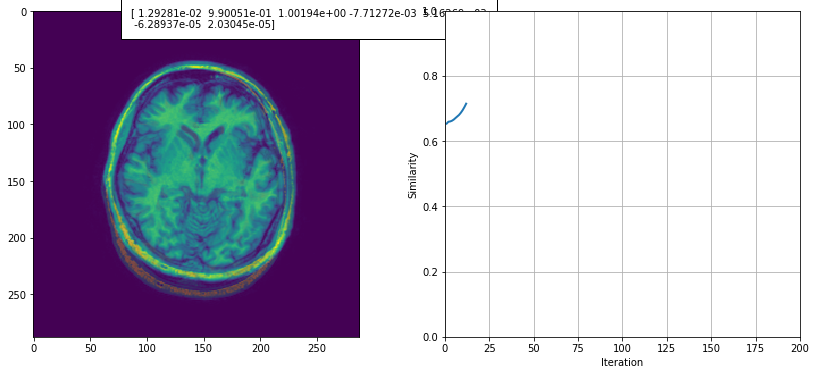

In [1]:
%matplotlib inline
import sys
sys.path.append("../code")
from registration_project import intensity_based_registration_demo


intensity_based_registration_demo()

By changing the similarity function and the initial parameter vector, you can also use this script to perform affine registration and use mutual information as a similarity measure. 

Using the provided dataset and the functions that you have implemented in the exercises, perform the following series of experiments:

1. Rigid intensity-based registration of two T1 slices (e.g. `1_1_t1.tif` and `1_1_t1_d.tif`) using normalized cross-correlation as a similarity measure.
2. Affine intensity-based registration of two T1 slices (e.g. `1_1_t1.tif` and `1_1_t1_d.tif`) using normalized cross-correlation as a similarity measure.
3. Affine intensity-based registration of a T1 and a T2 slice (e.g. `1_1_t1.tif` and `1_1_t2.tif`) using normalized cross-correlation as a similarity measure.
4. Affine intensity-based registration of two T1 slices (e.g. `1_1_t1.tif` and `1_1_t1_d.tif`) using mutual information as a similarity measure.
5. Affine intensity-based registration of a T1 slice and a T2 slice (e.g. `1_1_t1.tif` and `1_1_t2.tif`) using mutual information as a similarity measure.

Describe, analyze and compare the results from each experiment. If a method fails, describe why you think it fails. Note that you will most likely have to try different values for the learning rate in each experiment in order to find the one that works best. 

In [1]:
import sys
sys.path.append("../code")
import registration_pro as project
import matplotlib.pyplot as plt

I = plt.imread('../data/image_data/1_1_t1.tif')
Im = plt.imread('../data/image_data/1_1_t1_d.tif')
Im2 = plt.imread('../data/image_data/1_1_t2.tif')

project.intensity_based_registration(I, Im, Affine=True, MI=False)
#project.intensity_based_registration(I, Im, MI=False)
#project.intensity_based_registration(I, Im2, MI=False)
#project.intensity_based_registration(I, Im) #very, VERY slow
#project.intensity_based_registration(I, Im2) #very, VERY slow

<Figure size 1400x600 with 2 Axes>

CC = [0.99022329] for the affine intensity-based registration after 200 iterations with a computation time of 30.427247146999996
